In [32]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Utility Functions

In [2]:
def make_key_invariant(chromagram):
    """Returns a key-invariant chromagram."""
    maj_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    min_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    avg_chroma = np.mean(chromagram, axis=1)
    maj_corrs = np.correlate(avg_chroma, maj_profile, mode='same')
    min_corrs = np.correlate(avg_chroma, min_profile, mode='same')
    key_shift = np.argmax(np.concatenate((maj_corrs, min_corrs))) % 12
    return np.roll(chromagram, -key_shift, axis=0)


def find_anchor_frame(beats, tempo, sr, hop_length):
    """Determine the first beat frame that best matches the expected beat interval given a tempo and sample rate."""
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr, hop_length=hop_length))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]


def create_beat_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, duration_in_frames):
    """
    Create a grid of beats and meters based on the tempo, time signature, and detected beats of the song.
    
    Parameters:
    beats (np.ndarray): The frame locations of the beats in the song.
    anchor_frame (int): The first beat frame that best matches the expected beat interval.
    beat_interval_in_frames (int): The expected interval between beats in frames.
    time_signature (int): The time signature of the song.
    duration_in_frames (int): The total duration of the song in frames.
    
    Returns:
    beat_grid (np.ndarray): The timestamps of the beats in the song.
    meter_grid (np.ndarray): The timestamps of the meter boundaries in the song.
    """
    anchor_frame = beats[0] if anchor_frame is None else anchor_frame
    beat_grid = np.arange(anchor_frame, -beat_interval_in_frames, -beat_interval_in_frames)
    beat_grid = beat_grid[beat_grid >= 0]
    
    meter_grid = np.arange(beat_grid[0], duration_in_frames + 1, beat_interval_in_frames * time_signature)
    meter_grid = np.unique(np.concatenate((meter_grid, [0, duration_in_frames])))
    
    return beat_grid, meter_grid



def generate_and_align_labels_optimized(df, sr, hop_length, n_frames, measure_grid_frames):
    """Create a binary label sequence for 'chorus' in a song and align it to a measure grid, optimized."""
    binary_label_sequence = np.zeros(n_frames, dtype=int)
    chorus_rows = df[df['label'] == 'chorus']
    start_frames = librosa.time_to_frames(chorus_rows['start_time'].to_numpy(), sr=sr, hop_length=hop_length)
    end_frames = librosa.time_to_frames(chorus_rows['end_time'].to_numpy(), sr=sr, hop_length=hop_length)
    for start_frame, end_frame in zip(start_frames, end_frames):
        binary_label_sequence[start_frame:end_frame] = 1
    aligned_labels = [
        int(np.mean(binary_label_sequence[s:e]) >= 0.25)  # Threshold to determine if the measure is labeled as chorus
        for s, e in zip(measure_grid_frames[:-1], measure_grid_frames[1:])
    ]
    return np.array(aligned_labels)

def segment_data_measures(data, measure_grid_frames):
    """Divide song data into segments based on measure grid frames."""
    return [data[s:e] for s, e in zip(measure_grid_frames[:-1], measure_grid_frames[1:])]


def positional_encoding(position, d_model):
    """Generate a positional encoding for a given position and model dimension."""
    angle_rads = (
        np.arange(position)[:, np.newaxis] /
        np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    )
    return np.concatenate([np.sin(angle_rads[:, 0::2]), np.cos(angle_rads[:, 1::2])], axis=-1)


def apply_hierarchical_positional_encoding(segments):
    """Apply positional encoding at the meter and frame levels to a list of segments."""
    n_features = segments[0].shape[1]
    measure_level_encodings = positional_encoding(len(segments), n_features)
    return [
        seg + positional_encoding(len(seg), n_features) + measure_level_encodings[i] 
        for i, seg in enumerate(segments)
    ]

## Data Extraction

In [52]:
# Load data
df = pd.read_csv('../data/dataframes/clean_labeled.csv')

# Prepare directories
segment_dir = "../data/pkl/segments3"
labels_dir = "../data/pkl/labels3"
os.makedirs(segment_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

TARGET_SR = 12000 # Target sample rate chosen to be 1/4 of the original 48kHz.
HOP_LENGTH = 128  # Hop length for short-time Fourier transform. Hop length of 128 at 12kHz gives a similar frame rate to a hop length of 512 at 48kHz.

# Process DataFrame by SongID
for song_id in tqdm(df['SongID'].unique(), desc="Processing..."):
    # Load the audio file
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_path, sr=TARGET_SR)

    # Harmonic-percussive source separation
    y_harm, y_perc = librosa.effects.hpss(y)

    # Compute RMS energy from spectrogram to give a more accurate representation of energy over time because its frames can be windowed
    S = np.abs(librosa.stft(y, hop_length=HOP_LENGTH))
    rms = librosa.feature.rms(S=S)
    
    # Compute Mel Spectrogram and decompose into 4 components (4 chosen from EDA)
    mel = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, hop_length=HOP_LENGTH)
    mel_acts = librosa.decompose.decompose(mel, n_components=4, sort=True)[1]
    
    # Compute chromagram, make it key invariant, and decompose 
    chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=TARGET_SR, hop_length=HOP_LENGTH)
    chroma_ki = make_key_invariant(chromagram)
    chroma_acts = librosa.decompose.decompose(chroma_ki, n_components=3, sort=True)[1]
    
    # Compute tempogram, ensure non-negative b/c tempograms are finicky, and decompose 
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=TARGET_SR, hop_length=HOP_LENGTH)
    tempogram = np.clip(librosa.feature.tempogram(onset_envelope=onset_env, sr=TARGET_SR, hop_length=HOP_LENGTH), 0, None)
    tempogram_acts = librosa.decompose.decompose(tempogram, n_components=3, sort=True)[1]
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=TARGET_SR, n_mfcc=13, hop_length=HOP_LENGTH)
    
    # Calculate dimensions, total inverse dimension, and weights
    features = [rms, mel_acts, chroma_ki, chroma_acts, tempogram_acts, mfccs]
    feature_names = ['rms', 'mel_acts', 'chroma_ki', 'chroma_acts', 'tempogram_acts', 'mfccs']

    # Calculate dimensions and weights
    dims = {name: feature.shape[0] for feature, name in zip(features, feature_names)}
    total_inv_dim = sum(1.0 / dim for dim in dims.values())
    weights = {name: 1.0 / (dims[name] * total_inv_dim) for name in feature_names}

    # Standardize and apply weights
    standardized_weighted_features = [StandardScaler().fit_transform(feature.T).T * weights[name]
                                       for feature, name in zip(features, feature_names)]
    
    # Stack/concat features
    combined_features = np.concatenate(standardized_weighted_features, axis=0).T
 
    # Tempo and beat tracking
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=TARGET_SR, hop_length=HOP_LENGTH)
    beat_times = librosa.frames_to_time(beats, sr=TARGET_SR, hop_length=HOP_LENGTH)
    data = df.loc[df['SongID'] == song_id]
    bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])
    beat_interval_in_frames = librosa.time_to_frames(60/bpm, sr=TARGET_SR, hop_length=HOP_LENGTH)

    # Measure grid creation and label alignment
    anchor_frame = find_anchor_frame(beats, bpm, TARGET_SR, HOP_LENGTH)
    beat_grid, meter_grid = create_beat_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, len(combined_features))
    aligned_labels = generate_and_align_labels(data, sr=TARGET_SR, hop_length=HOP_LENGTH, n_frames=len(combined_features), measure_grid_frames=meter_grid)
    meter_segments = segment_data_measures(combined_features, meter_grid)
    
    # Apply Hierarchical Positional Encoding
    encoded_segments = apply_hierarchical_positional_encoding(meter_segments)

    # Save results
    with open(f"{segment_dir}/{song_id}_data.pkl", "wb") as f:
        pickle.dump(encoded_segments, f)
    with open(f"{labels_dir}/{song_id}_labels.pkl", "wb") as f:
        pickle.dump(aligned_labels, f)

Processing...: 100%|██████████| 332/332 [59:17<00:00, 10.72s/it] 


## Load pickled data

In [4]:
def load_pickles_from_directory(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data.append(data)
    return all_data
    
# Directories containing the pickled files
segment_dir = "../data/pkl/segments3"
labels_dir = "../data/pkl/labels3"

# Load all segments and labels
all_segments = load_pickles_from_directory(segment_dir)
all_labels = load_pickles_from_directory(labels_dir)

# all_segments is a 3D array of `[n_songs, n_segments, 36]`, where `n_segments` varies per song and may require additional padding for consistent processing.

## Padding and reshaping

In [6]:
def find_max_frames_and_meters(all_segments):
    """Find the maximum number of frames per measure and the maximum number of measures across all songs."""
    max_frames_per_measure = max(max(m.shape[0] for m in s) for s in all_segments)
    max_measures = max(len(s) for s in all_segments)
    return max_frames_per_measure, max_measures

def pad_measures(all_segments, max_frames_per_measure):
    """Pad all measures within each song to have the same number of frames with zero padding."""
    padded_measures = [
        [np.pad(m, ((0, max_frames_per_measure - m.shape[0]), (0, 0)), 'constant', constant_values=0) for m in song]
        for song in all_segments
    ]
    return padded_measures

def pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features):
    """Pad all songs to have the same number of measures with zero padding."""
    padding_measure = np.zeros((max_frames_per_measure, n_features))
    padded_songs = [
        song + [padding_measure] * (max_measures - len(song)) for song in padded_measures
    ]
    return padded_songs

def pad_labels(all_labels, max_measures):
    """Pad all label sequences to have the same number of measures with -1 padding."""
    return [np.pad(labels, (0, max_measures - len(labels)), 'constant', constant_values=-1)
            for labels in all_labels]

n_features = all_segments[0][0].shape[1]
max_frames_per_measure, max_measures = find_max_frames_and_meters(all_segments) # Find the maximum frames per measure and maximum measures across all songs
padded_measures = pad_measures(all_segments, max_frames_per_measure) # pad measures within each song to have the same number of frames
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features) # pad all songs to have the same number of measures
padded_labels = pad_labels(all_labels, max_measures) # Pad labels to match the structure of padded_segments

## Generate train, validation, and test sets

In [8]:
def split_data(padded_songs, padded_labels):
    """Split the data into train, validation, and test sets."""
    num_songs = len(padded_songs)
    indices = np.arange(num_songs)
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
    
    X_train = [padded_songs[i] for i in train_indices]
    y_train = [padded_labels[i] for i in train_indices]
    X_val = [padded_songs[i] for i in val_indices]
    y_val = [padded_labels[i] for i in val_indices]
    X_test = [padded_songs[i] for i in test_indices]
    y_test = [padded_labels[i] for i in test_indices]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def data_generator(X, y):
    """Generator function to yield batches of data."""
    for features, labels in zip(X, y):
        # Convert features to a NumPy array with shape: (num_measures, num_frames, 32)
        features_array = np.array(features)
        
        # Reshape labels to have an additional dimension: (num_measures, 1)
        labels_reshaped = np.expand_dims(labels, axis=-1)
        
        yield features_array, labels_reshaped

def create_dataset(X, y, batch_size, n_features):
    """Create a TensorFlow dataset from the generator function."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, n_features), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    ).batch(batch_size)
    
    return dataset

# Split the data into train, validation, and test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(padded_songs, padded_labels)

# Define the batch size as the number of songs per batch
batch_size = 32

# Create the train, validation, and test datasets
train_dataset = create_dataset(X_train, y_train, batch_size, n_features)
val_dataset = create_dataset(X_val, y_val, batch_size, n_features)
test_dataset = create_dataset(X_test, y_test, batch_size, n_features)

## Define CRNN model and custom loss/accuracy and metrics

In [9]:
def custom_binary_crossentropy(y_true, y_pred):
    """Custom binary cross-entropy loss to handle -1 labels, which are used for padding and should be ignored during loss calculation."""
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    """Custom accuracy metric to handle -1 labels, which are used for padding and should be ignored during accuracy calculation."""
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy

def create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame):
    """
    Args:
    max_frames_per_measure (int): Maximum number of frames per measure.
    max_measures (int): Maximum number of measures.
    feature_per_frame (int): Number of features per frame.
    """
    frame_input = layers.Input(shape=(max_frames_per_measure, feature_per_frame))
    conv1 = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(frame_input)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv2 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv3 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    frame_features = layers.Flatten()(pool3)
    frame_feature_model = Model(inputs=frame_input, outputs=frame_features)

    measure_input = layers.Input(shape=(max_measures, max_frames_per_measure, feature_per_frame))
    time_distributed = layers.TimeDistributed(frame_feature_model)(measure_input)
    masking_layer = layers.Masking(mask_value=0.0)(time_distributed)
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(masking_layer)
    output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(lstm_out)
    model = Model(inputs=measure_input, outputs=output)
    model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=[custom_accuracy])
    return model

In [10]:
feature_per_frame = n_features
#max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)
model = create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 204, 296, 36)]    0         
                                                                 
 time_distributed (TimeDistr  (None, 204, 9472)        309376    
 ibuted)                                                         
                                                                 
 masking (Masking)           (None, 204, 9472)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 204, 512)         19924992  
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 1)           513       
 tributed)                                                       
                                                           

## Train the model

In [17]:
def train_model(model, model_name, epochs=10, train_dataset=train_dataset, val_dataset=val_dataset):
    """Trains a given model and saves the best version based on minimizing loss."""

    # Define the directories for checkpoints and models
    checkpoint_dir = os.path.join('..', 'checkpoints', 'CRNN')
    model_dir = os.path.join('..', 'models', 'CRNN')

    # Ensure the checkpoint and model directories exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # Define the checkpoint path for the best model
    best_model_filepath = os.path.join(model_dir, model_name + '.h5')

    callbacks = [
        ModelCheckpoint(
            filepath=best_model_filepath,
            save_weights_only=False,
            monitor='val_loss', 
            mode='min',  # 'min' since we want to minimize loss
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=2,
            verbose=1,
            min_delta=0.0001,
            min_lr=0.00001
        )
    ]

    # Train the model with the simplified callbacks list
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    return history

history = train_model(model, 'best_model', epochs=20)

Epoch 1/20
      8/Unknown - 49s 6s/step - loss: 0.5483 - custom_accuracy: 0.7068
Epoch 1: val_loss improved from inf to 0.52319, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 53s 7s/step - loss: 0.5483 - custom_accuracy: 0.7068 - val_loss: 0.5232 - val_custom_accuracy: 0.7332 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.5141 - custom_accuracy: 0.7417
Epoch 2: val_loss improved from 0.52319 to 0.49905, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 53s 7s/step - loss: 0.5141 - custom_accuracy: 0.7417 - val_loss: 0.4991 - val_custom_accuracy: 0.7527 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.4742 - custom_accuracy: 0.7720
Epoch 3: val_loss improved from 0.49905 to 0.47222, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 54s 7s/step - loss: 0.4742 - custom_accuracy: 0.7720 - val_loss: 0.4722 - val_custom_a

## Evaluate model

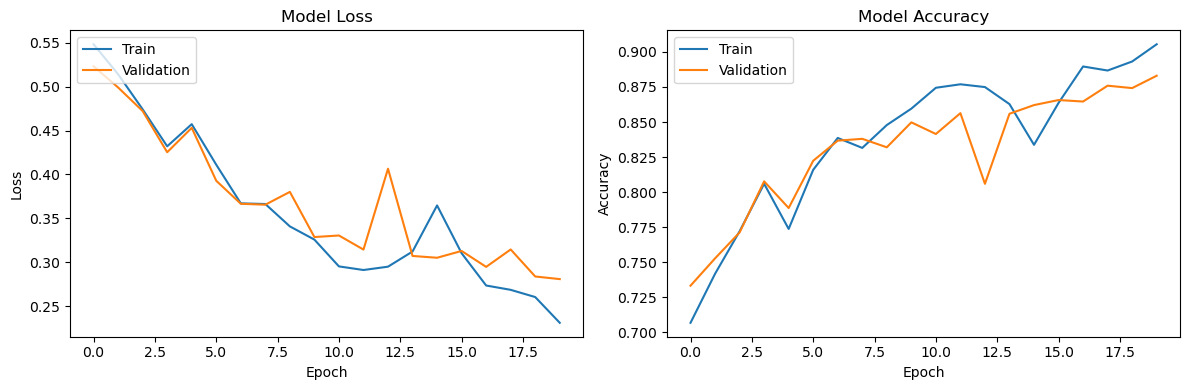

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['custom_accuracy'])  
    plt.plot(history.history['val_custom_accuracy'])  
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Adding dropout although it might not be neccessary

In [19]:
def create_crnn_model_with_dropout(max_frames_per_measure, max_measures, feature_per_frame):
    frame_input = layers.Input(shape=(max_frames_per_measure, feature_per_frame))
    conv1 = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(frame_input)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    dropout1 = layers.Dropout(0.3)(pool1)
    conv2 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(dropout1)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    dropout2 = layers.Dropout(0.3)(pool2)
    conv3 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(dropout2)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    frame_features = layers.Flatten()(pool3)
    frame_feature_model = Model(inputs=frame_input, outputs=frame_features)

    measure_input = layers.Input(shape=(max_measures, max_frames_per_measure, feature_per_frame))
    time_distributed = layers.TimeDistributed(frame_feature_model)(measure_input)
    masking_layer = layers.Masking(mask_value=0.0)(time_distributed)
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(masking_layer)
    output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(lstm_out)
    model = Model(inputs=measure_input, outputs=output)
    model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=[custom_accuracy])
    return model

model_with_dropout = create_crnn_model_with_dropout(max_frames_per_measure, max_measures, feature_per_frame)
model_with_dropout.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 204, 296, 36)]    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 9472)        309376    
 tributed)                                                       
                                                                 
 masking_1 (Masking)         (None, 204, 9472)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 512)         19924992  
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 1)           513       
 tributed)                                                       
                                                           

In [ ]:
history2 = train_model(model_with_dropout, "best_model_with_dropout", epochs=30, train_dataset=train_dataset, val_dataset=val_dataset)

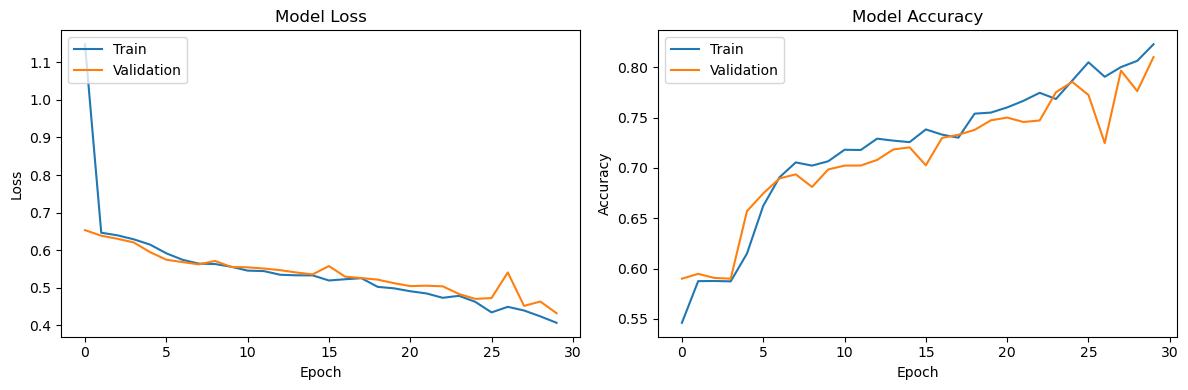

In [22]:
plot_training_history(history2)

## Evaluate the model

In [23]:
# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

# Load the best model
model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model.h5')
best_model = load_model(best_model_filepath, custom_objects=custom_objects)

# Evaluate the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 5s 2s/step - loss: 0.2343 - custom_accuracy: 0.8997
Test Loss: 0.2343151718378067
Test Accuracy: 0.8996654748916626


In [24]:
predictions = best_model.predict(test_dataset)
predicted_labels = np.round(predictions).astype(int) 

2/2 [==============================] - 4s 1s/step


In [34]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy()) 

true_labels = np.array(true_labels).astype(int) 

# Flatten the arrays
true_labels_flat = true_labels.flatten()
predicted_labels_flat = predicted_labels.flatten()

# Exclude indices with -1 in true labels
valid_indices = true_labels_flat != -1

# Filter both true and predicted labels to include only valid indices
true_labels_filtered = true_labels_flat[valid_indices]
predicted_labels_filtered = predicted_labels_flat[valid_indices]

# Calculate F1 score
f1 = f1_score(true_labels_filtered, predicted_labels_filtered, average='binary')

print(f"F1 Score: {f1:.3f}")

F1 Score: 0.876


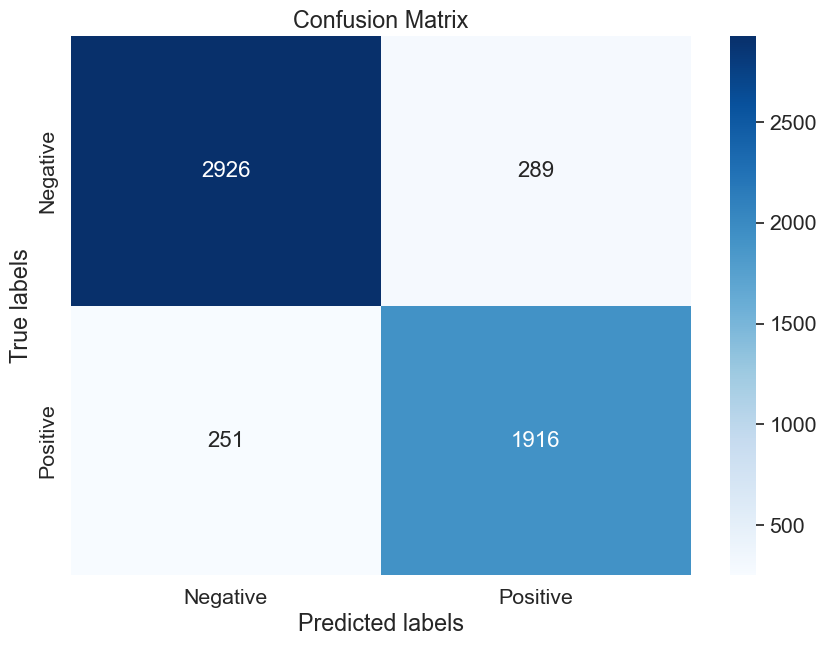

In [33]:
cm = confusion_matrix(true_labels_filtered, predicted_labels_filtered)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Visualizing model predictions 

In [35]:
import os
import pickle

def load_pickles_from_directory(directory, data_type):
    all_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            # Extract the songid from the filename
            # The filename is expected to be in the format "{song_id}_{data_type}.pkl"
            song_id = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data[song_id] = data  # Use song_id as key
    return all_data

# Directories containing the pickled files
segment_dir = "../data/pkl/segments3"
labels_dir = "../data/pkl/labels3"

# Load all segments and labels
# Specify the data type when calling the function
all_segments = load_pickles_from_directory(segment_dir, "data")
all_labels = load_pickles_from_directory(labels_dir, "labels")

In [37]:
def find_max_frames_and_meters(all_segments):
    """Find the maximum number of frames per measure and the maximum number of measures across all songs in the dictionary."""
    max_frames_per_measure = max([max([m.shape[0] for m in song]) for song in all_segments.values()])
    max_measures = max([len(song) for song in all_segments.values()])
    return max_frames_per_measure, max_measures

def pad_measures(all_segments, max_frames_per_measure, n_features):
    """Pad all measures within each song to have the same number of frames with zero padding."""
    padded_segments = {}
    for song_id, segments in all_segments.items():
        padded_segments[song_id] = [np.pad(m, ((0, max_frames_per_measure - m.shape[0]), (0, 0)), 'constant', constant_values=0) for m in segments]
    return padded_segments

def pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features):
    """Pad all songs to have the same number of measures with zero padding."""
    padded_songs = {}
    padding_measure = np.zeros((max_frames_per_measure, n_features))
    for song_id, measures in padded_measures.items():
        padded_songs[song_id] = measures + [padding_measure] * (max_measures - len(measures))
    return padded_songs

def pad_labels(all_labels, max_measures):
    """Pad all label sequences to have the same number of measures with -1 padding."""
    padded_labels = {}
    for song_id, labels in all_labels.items():
        padded_labels[song_id] = np.pad(labels, (0, max_measures - len(labels)), 'constant', constant_values=-1)
    return padded_labels

# Assuming n_features is known, e.g., from the preprocessing steps
n_features = next(iter(all_segments.values()))[0].shape[1]
max_frames_per_measure, max_measures = find_max_frames_and_meters(all_segments)
padded_measures = pad_measures(all_segments, max_frames_per_measure, n_features)
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features)
padded_labels = pad_labels(all_labels, max_measures)

In [38]:
def split_data_dict(padded_songs, padded_labels):
    """Split the dataset (now in dictionary form) into train, validation, and test sets."""
    song_ids = list(padded_songs.keys())
    train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
    
    # Split the data based on the ids
    X_train = {song_id: padded_songs[song_id] for song_id in train_ids}
    y_train = {song_id: padded_labels[song_id] for song_id in train_ids}
    
    X_val = {song_id: padded_songs[song_id] for song_id in val_ids}
    y_val = {song_id: padded_labels[song_id] for song_id in val_ids}
    
    X_test = {song_id: padded_songs[song_id] for song_id in test_ids}
    y_test = {song_id: padded_labels[song_id] for song_id in test_ids}
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Adapt the generator function to work with dictionary inputs
def data_generator_dict(X, y):
    """Generator function to yield batches of data from dictionaries."""
    for song_id in X.keys():
        features = np.array(X[song_id])
        labels = np.expand_dims(y[song_id], axis=-1)
        yield features, labels

# Adjust the create_dataset function for dictionary inputs and to handle variable input shapes
def create_dataset_dict(X, y, batch_size, n_features):
    """Create a TensorFlow dataset from the generator function for dictionary inputs."""
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator_dict(X, y),
        output_signature=(
            tf.TensorSpec(shape=(None, None, n_features), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    ).batch(batch_size, drop_remainder=True) # Consider using drop_remainder=True to handle variable sizes
    
    return dataset

# Use the adjusted functions to split the data and create datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_data_dict(padded_songs, padded_labels)
train_dataset = create_dataset_dict(X_train, y_train, batch_size, n_features)
val_dataset = create_dataset_dict(X_val, y_val, batch_size, n_features)
test_dataset = create_dataset_dict(X_test, y_test, batch_size, n_features)

In [39]:
def custom_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def custom_accuracy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)
    return accuracy

# Define custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

model_dir = os.path.join('..', 'models', 'CRNN')
best_model_filepath = os.path.join(model_dir, 'best_model.h5')
model = load_model(best_model_filepath, custom_objects=custom_objects)

In [81]:
def find_anchor_frame(beats, tempo, sr=12000, hop_length=128):
    """Determine the first beat frame that best matches the expected beat interval given a tempo and sample rate."""
    expected_interval = int(librosa.time_to_frames(60.0 / tempo, sr=sr, hop_length=hop_length))
    best_match_start = max((1 - abs(np.mean(beats[i:i+3]) - expected_interval) / expected_interval, beats[i]) for i in range(len(beats) - 2))[1]
    return best_match_start if best_match_start > 0.95 else beats[0]

def create_beat_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, duration_in_frames):
    """Create a grid of beats and meters based on the tempo, time signature, and detected beats of the song."""
    anchor_frame = beats[0] if anchor_frame is None else anchor_frame
    beat_grid = np.arange(anchor_frame, -beat_interval_in_frames, -beat_interval_in_frames)
    beat_grid = beat_grid[beat_grid >= 0]
    meter_grid = np.arange(beat_grid[0], duration_in_frames + 1, beat_interval_in_frames * time_signature)
    meter_grid = np.unique(np.concatenate((meter_grid, [0, duration_in_frames])))
    return beat_grid, meter_grid

def apply_measure_grid(ax, measure_grid_times):
    for time in measure_grid_times:
        ax.axvline(x=time, color='grey', linestyle='--', linewidth=1, alpha=0.6)
        
def highlight_predictions(ax, unpadded_predictions, true_labels, measure_grid_times, sr):
    """Overlay the predicted sections based on the measure grid, predictions array, and true labels."""
    # Define colors for each type of prediction, with NN as transparent black
    colors = {'PP': 'green', 'NN': (0, 0, 0, 0.5), 'NP': 'red', 'PN': 'orange'}
    # Initialize a dictionary to keep track of whether a legend item has been added
    legend_added = {'PP': False, 'NN': False, 'NP': False, 'PN': False}

    for measure_index in range(len(unpadded_predictions)):
        if measure_index == len(measure_grid_times) - 1:
            # Prevent index out of range
            break
        start_time = measure_grid_times[measure_index]
        end_time = measure_grid_times[measure_index + 1]

        # Determine prediction type (PP, NN, NP, PN)
        if unpadded_predictions[measure_index] == 1 and true_labels[measure_index] == 1:
            pred_type = 'PP'
        elif unpadded_predictions[measure_index] == 0 and true_labels[measure_index] == 0:
            pred_type = 'NN'
        elif unpadded_predictions[measure_index] == 1 and true_labels[measure_index] == 0:
            pred_type = 'PN'
        elif unpadded_predictions[measure_index] == 0 and true_labels[measure_index] == 1:
            pred_type = 'NP'
        else:
            continue  # Skip if none of the above

        color = colors[pred_type]
        label = pred_type if not legend_added[pred_type] else None
        legend_added[pred_type] = True

        # Highlight the measure
        ax.axvspan(start_time, end_time, color=color, alpha=0.3, label=label)

    # Update the legend to avoid duplicates
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='best')
        
def prototype_visualization(song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='../images/test_predictions'):
    """
    Prototype the visualization for a single song.
    
    Parameters:
    - song_id: ID of the song to visualize.
    - X_test: Test dataset features.
    - y_test: Test dataset labels.
    - model: Trained model.
    - sr: Sample rate.
    - hop_length: Hop length used for feature extraction.
    - save_dir: Directory to save the visualization.
    """
    features = np.array(X_test[song_id])
    true_labels = y_test[song_id]
    predictions = model.predict(np.expand_dims(features, axis=0)).squeeze()
    
    # Calculate F1 score for the song
    predictions_binary = predictions.round()
    valid_indices = true_labels != -1
    filtered_true_labels = true_labels[valid_indices]
    filtered_predictions = predictions_binary[valid_indices]
    f1 = f1_score(filtered_true_labels, filtered_predictions, average='binary')
    
    # Load song data
    song_id = int(song_id)
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=sr)
    y_perc = librosa.effects.hpss(y)[1]
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    duration_in_frames = len(onset_env)
    
    data = df[df['SongID'] == song_id]
    bpm = data['sp_tempo'].fillna(tempo).replace(0, tempo).clip(lower=70, upper=140).values[0]
    time_signature = int(data['sp_time_signature'].fillna(4).replace(0, 4).values[0])

    anchor_frame = find_anchor_frame(beats, bpm, sr, hop_length)
    beat_interval_in_frames = librosa.time_to_frames(60.0 / bpm, sr=sr, hop_length=hop_length)
    _, meter_grid = create_beat_grid(beats, anchor_frame, beat_interval_in_frames, time_signature, duration_in_frames)
    meter_grid_times = librosa.frames_to_time(meter_grid, sr=sr, hop_length=hop_length)
    
    # Visualize waveform and predictions
    fig, ax = plt.subplots(figsize=(14, 6))
    librosa.display.waveshow(y, sr=sr, ax=ax)
    
    ax.set_xlim(0, librosa.get_duration(y=y, sr=12000, hop_length=128))
    apply_measure_grid(ax, meter_grid_times)
    highlight_predictions(ax, filtered_predictions, filtered_true_labels, meter_grid_times, sr)
    
    ax.set_ylabel('Amplitude')
    plt.title(f'Predictions for Song #{song_id} ({f1:.3f} F1 Score)')
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_dir, f'{song_id}.png'))
    plt.close()
    
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
song_ids = list(X_test.keys())
#random_song_id = np.random.choice(song_ids)

for random_song_id in tqdm(song_ids):
    prototype_visualization(random_song_id, X_test, y_test, model, df, sr=12000, hop_length=128, save_dir='C:/Users/denni/OneDrive/Desktop/chorus-detection/images/test_predictions')

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 428ms/step


  2%|▏         | 1/50 [00:09<07:30,  9.20s/it]

1/1 [==============================] - 0s 433ms/step


  4%|▍         | 2/50 [00:16<06:24,  8.00s/it]

1/1 [==============================] - 0s 417ms/step


  6%|▌         | 3/50 [00:22<05:28,  6.98s/it]

1/1 [==============================] - 0s 419ms/step


  8%|▊         | 4/50 [00:29<05:35,  7.29s/it]

1/1 [==============================] - 0s 418ms/step


 10%|█         | 5/50 [00:36<05:15,  7.01s/it]

1/1 [==============================] - 0s 432ms/step


 12%|█▏        | 6/50 [00:44<05:28,  7.47s/it]

1/1 [==============================] - 0s 430ms/step


 14%|█▍        | 7/50 [00:52<05:29,  7.67s/it]

1/1 [==============================] - 0s 462ms/step


 16%|█▌        | 8/50 [01:03<05:57,  8.50s/it]

1/1 [==============================] - 0s 438ms/step


 18%|█▊        | 9/50 [01:09<05:17,  7.75s/it]

1/1 [==============================] - 0s 435ms/step


 20%|██        | 10/50 [01:15<04:51,  7.29s/it]

1/1 [==============================] - 0s 442ms/step


 22%|██▏       | 11/50 [01:21<04:29,  6.91s/it]

1/1 [==============================] - 0s 482ms/step


 24%|██▍       | 12/50 [01:30<04:40,  7.39s/it]

1/1 [==============================] - 0s 434ms/step


 26%|██▌       | 13/50 [01:40<05:07,  8.32s/it]

1/1 [==============================] - 0s 427ms/step


 28%|██▊       | 14/50 [01:46<04:33,  7.59s/it]

1/1 [==============================] - 0s 411ms/step


 30%|███       | 15/50 [01:54<04:27,  7.64s/it]

1/1 [==============================] - 0s 435ms/step


 32%|███▏      | 16/50 [02:02<04:26,  7.83s/it]

1/1 [==============================] - 0s 425ms/step


 34%|███▍      | 17/50 [02:09<04:06,  7.48s/it]

1/1 [==============================] - 0s 426ms/step


 36%|███▌      | 18/50 [02:16<03:59,  7.47s/it]

1/1 [==============================] - 0s 498ms/step


 38%|███▊      | 19/50 [02:28<04:38,  8.97s/it]

1/1 [==============================] - 0s 430ms/step


 40%|████      | 20/50 [02:35<04:06,  8.22s/it]

1/1 [==============================] - 0s 416ms/step


 42%|████▏     | 21/50 [02:45<04:16,  8.86s/it]

1/1 [==============================] - 0s 441ms/step


 44%|████▍     | 22/50 [02:51<03:38,  7.81s/it]

1/1 [==============================] - 0s 420ms/step


 46%|████▌     | 23/50 [02:58<03:26,  7.65s/it]

1/1 [==============================] - 0s 425ms/step


 48%|████▊     | 24/50 [03:06<03:20,  7.72s/it]

1/1 [==============================] - 0s 409ms/step


 50%|█████     | 25/50 [03:12<03:04,  7.36s/it]

1/1 [==============================] - 0s 414ms/step


 52%|█████▏    | 26/50 [03:23<03:19,  8.30s/it]

1/1 [==============================] - 0s 409ms/step


 54%|█████▍    | 27/50 [03:29<02:56,  7.67s/it]

1/1 [==============================] - 0s 418ms/step


 56%|█████▌    | 28/50 [03:37<02:52,  7.85s/it]

1/1 [==============================] - 0s 449ms/step


 58%|█████▊    | 29/50 [03:44<02:40,  7.64s/it]

1/1 [==============================] - 0s 423ms/step


 60%|██████    | 30/50 [03:55<02:48,  8.44s/it]

1/1 [==============================] - 0s 421ms/step


 62%|██████▏   | 31/50 [04:02<02:31,  7.98s/it]

1/1 [==============================] - 0s 420ms/step


 64%|██████▍   | 32/50 [04:09<02:22,  7.89s/it]

1/1 [==============================] - 0s 426ms/step


 66%|██████▌   | 33/50 [04:20<02:29,  8.78s/it]

1/1 [==============================] - 0s 414ms/step


 68%|██████▊   | 34/50 [04:27<02:12,  8.28s/it]

1/1 [==============================] - 0s 422ms/step


 70%|███████   | 35/50 [04:36<02:06,  8.44s/it]

1/1 [==============================] - 0s 415ms/step


 72%|███████▏  | 36/50 [04:43<01:51,  7.99s/it]

1/1 [==============================] - 0s 408ms/step


 74%|███████▍  | 37/50 [04:51<01:42,  7.88s/it]

1/1 [==============================] - 0s 418ms/step


 76%|███████▌  | 38/50 [04:59<01:36,  8.01s/it]

1/1 [==============================] - 0s 425ms/step


 78%|███████▊  | 39/50 [05:07<01:26,  7.87s/it]

1/1 [==============================] - 0s 417ms/step


 80%|████████  | 40/50 [05:18<01:28,  8.90s/it]

1/1 [==============================] - 0s 424ms/step


 82%|████████▏ | 41/50 [05:28<01:22,  9.17s/it]

1/1 [==============================] - 0s 429ms/step


 84%|████████▍ | 42/50 [05:34<01:07,  8.43s/it]

1/1 [==============================] - 0s 427ms/step


 86%|████████▌ | 43/50 [05:42<00:56,  8.08s/it]

1/1 [==============================] - 0s 409ms/step


 88%|████████▊ | 44/50 [05:50<00:48,  8.15s/it]

1/1 [==============================] - 0s 418ms/step


 90%|█████████ | 45/50 [05:57<00:39,  7.82s/it]

1/1 [==============================] - 0s 425ms/step


 92%|█████████▏| 46/50 [06:03<00:29,  7.32s/it]

1/1 [==============================] - 0s 426ms/step


 94%|█████████▍| 47/50 [06:11<00:22,  7.39s/it]

1/1 [==============================] - 0s 423ms/step


 96%|█████████▌| 48/50 [06:18<00:14,  7.33s/it]

1/1 [==============================] - 0s 430ms/step


 98%|█████████▊| 49/50 [06:24<00:06,  6.86s/it]

1/1 [==============================] - 0s 421ms/step


100%|██████████| 50/50 [06:31<00:00,  7.83s/it]


1/1 [==============================] - 1s 607ms/step


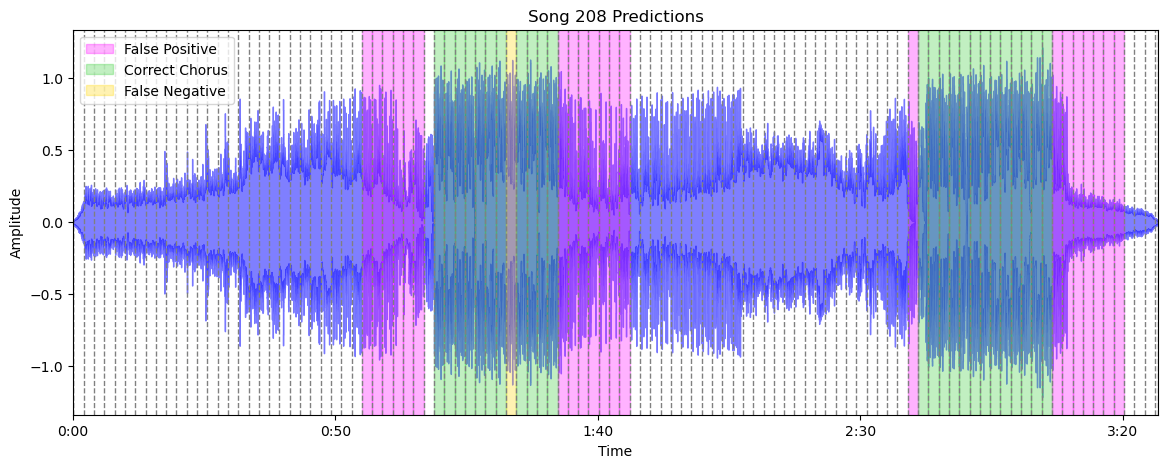